### Search Engine With Tools And Agents

1. https://groq.com/
2. https://python.langchain.com/v0.1/docs/modules/agents/
3. https://python.langchain.com/v0.1/docs/integrations/tools/
4. https://docs.smith.langchain.com/old/category/prompt-hub
5. langchain HUB Prompt 
	https://smith.langchain.com/hub/hwchase17/openai-functions-agent?organizationId=0d3dc86a-8ed9-40e0-96e5-f7359ba5d766
6. Agent Types  =
	https://python.langchain.com/v0.1/docs/modules/agents/agent_types/
7. React-agents =  
	https://python.langchain.com/v0.2/docs/concepts/#react-agents

In [1]:
## Arxiv--Research
## Tools creation 
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
## Used the inbuilt tool of wikipedia
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [ ]:
## Used the inbuilt tool of Arxiv
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=250)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [7]:
tools=[wiki,arxiv]

In [4]:
## Custom tools[RAG Tool]
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
loader=WebBaseLoader("https://docs.smith.langchain.com/")
docs=loader.load()
documents=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200).split_documents(docs)
vectordb=FAISS.from_documents(documents,OpenAIEmbeddings())
retriever=vectordb.as_retriever()
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000020717B83F50>, search_kwargs={})

In [8]:
# converting retriever into a tool

from langchain.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(retriever,"langsmith-search","Search any information about Langsmith ")
print(retriever_tool)
print("retriever_tool name : " ,retriever_tool.name)

name='langsmith-search' description='Search any information about Langsmith ' args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'> func=functools.partial(<function _get_relevant_documents at 0x0000020707700EA0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000020717B83F50>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content') coroutine=functools.partial(<function _aget_relevant_documents at 0x0000020707A59F80>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000020717B83F50>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='

In [ ]:
tools=[wiki,arxiv,retriever_tool]  # creating a 3 tools 

In [10]:
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'e:\\GENERATIVEAI\\ALL_LIVE\\AGENTICAI_JAN25KNA\\WORKSPACE\\testai\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=250)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=1, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=250)),
 Tool(name='langsmith-search', description='Search any information about Langsmith ', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000020707700EA0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS ob

In [12]:
## Run all this tools with Agents and LLM Models

## Tools, LLM-->AgentExecutor
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import openai
load_dotenv()
import os

groq_api_key=os.getenv("GROQ_API_KEY")
openai.api_key=os.getenv("OPENAI_API_KEY")

llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002075294C8F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002075294DA90>, model_name='Llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
## Prompt Template
from langchain import hub   # its a Promptemplate from a langchain whih provides a readymade promptTemplate
prompt=hub.pull("hwchase17/openai-functions-agent")
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [14]:
## Agents
from langchain.agents import create_openai_tools_agent
agent=create_openai_tools_agent(llm,tools,prompt)
agent

RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages

In [15]:
## Agent Executer : For executing a Agent
from langchain.agents import AgentExecutor
agent_executor=AgentExecutor(agent=agent,tools=tools,verbose=True)
agent_executor

AgentExecutor(verbose=True, agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag

In [16]:
agent_executor.invoke({"input":"Tell me about Langsmith"})



> Entering new AgentExecutor chain...

Invoking: `langsmith-search` with `{'query': 'what is Langsmith'}`


Get started with LangSmith | 🦜️🛠️ LangSmith

LangSmith + LangChain OSSLangSmith is framework-agnostic — it can be used with or without LangChain's open source frameworks langchain and langgraph.If you are using either of these, you can enable LangSmith tracing with a single environment variable.
For more see the how-to guide for setting up LangSmith with LangChain or setting up LangSmith with LangGraph.
Observability​
Observability is important for any software application, but especially so for LLM applications. LLMs are non-deterministic by nature, meaning they can produce unexpected results. This makes them trickier than normal to debug.
This is where LangSmith can help! LangSmith has LLM-native observability, allowing you to get meaningful insights from your application. LangSmith’s observability features have you covered throughout all stages of application development - f

{'input': 'Tell me about Langsmith',
 'output': "Thank you for the tool call result! Based on the output, LangSmith is a platform for building production-grade LLM (Large Language Model) applications. It provides various features such as observability, evaluation, and prompt engineering to help developers closely monitor and evaluate their applications, iterate on prompts, and optimize their performance.\n\nLangSmith allows developers to analyze traces, configure metrics and dashboards, and set up alerts. It also provides features for evaluating application performance, collecting human feedback, and creating high-quality evaluation datasets.\n\nAdditionally, LangSmith provides tools for prompt engineering, which is crucial for building effective AI applications. It helps developers find the perfect prompt for their application and enables collaboration and version control.\n\nOverall, LangSmith seems to be a powerful platform for building and optimizing LLM applications, and I'm happy

In [18]:
agent_executor.invoke({"input":"What is Generative AI?"})



> Entering new AgentExecutor chain...

Invoking: `wikipedia` with `{'query': 'Generative AI'}`


Page: Generative artificial intelligence
Summary: Generative artificial intelligence (generative AI, GenAI, or GAI) is a subset of artificial intelligence that uses generative models to produce text, images, videos, or other forms of data. These modeBased on the user's question and the tool's output, I'd like to provide a more comprehensive answer. Generative AI refers to a type of artificial intelligence that uses algorithms and machine learning techniques to generate new, original content, such as text, images, videos, or music. This type of AI is different from narrow or weak AI, which is designed to perform a specific task, like playing chess or recognizing images.

Generative AI models are trained on large datasets and can learn patterns and relationships within the data. Once trained, these models can generate new content that is similar in style and structure to the original data. 

{'input': 'What is Generative AI?',
 'output': "Based on the user's question and the tool's output, I'd like to provide a more comprehensive answer. Generative AI refers to a type of artificial intelligence that uses algorithms and machine learning techniques to generate new, original content, such as text, images, videos, or music. This type of AI is different from narrow or weak AI, which is designed to perform a specific task, like playing chess or recognizing images.\n\nGenerative AI models are trained on large datasets and can learn patterns and relationships within the data. Once trained, these models can generate new content that is similar in style and structure to the original data. This technology has many potential applications, such as:\n\n* Content creation: Generative AI can be used to generate high-quality content, such as articles, social media posts, or even entire books.\n* Image and video generation: Generative AI can generate realistic images and videos that can be 

In [17]:
agent_executor.invoke({"input":"What's the paper 1706.03762 about?"})



> Entering new AgentExecutor chain...

Invoking: `arxiv` with `{'query': '1706.03762'}`


Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on c
Invoking: `wikipedia` with `{'query': 'Attention Is All You Need'}`


Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer,The paper "Attention Is All You Need" is a 2017 research paper that introduced the transformer architecture, a type of deep learning model that is capable of handling sequential data, such as text or speech, without the need for traditional recurrent neural network (RNN) or convolutional neural network (CNN) architectures.

> Finished 

{'input': "What's the paper 1706.03762 about?",
 'output': 'The paper "Attention Is All You Need" is a 2017 research paper that introduced the transformer architecture, a type of deep learning model that is capable of handling sequential data, such as text or speech, without the need for traditional recurrent neural network (RNN) or convolutional neural network (CNN) architectures.'}

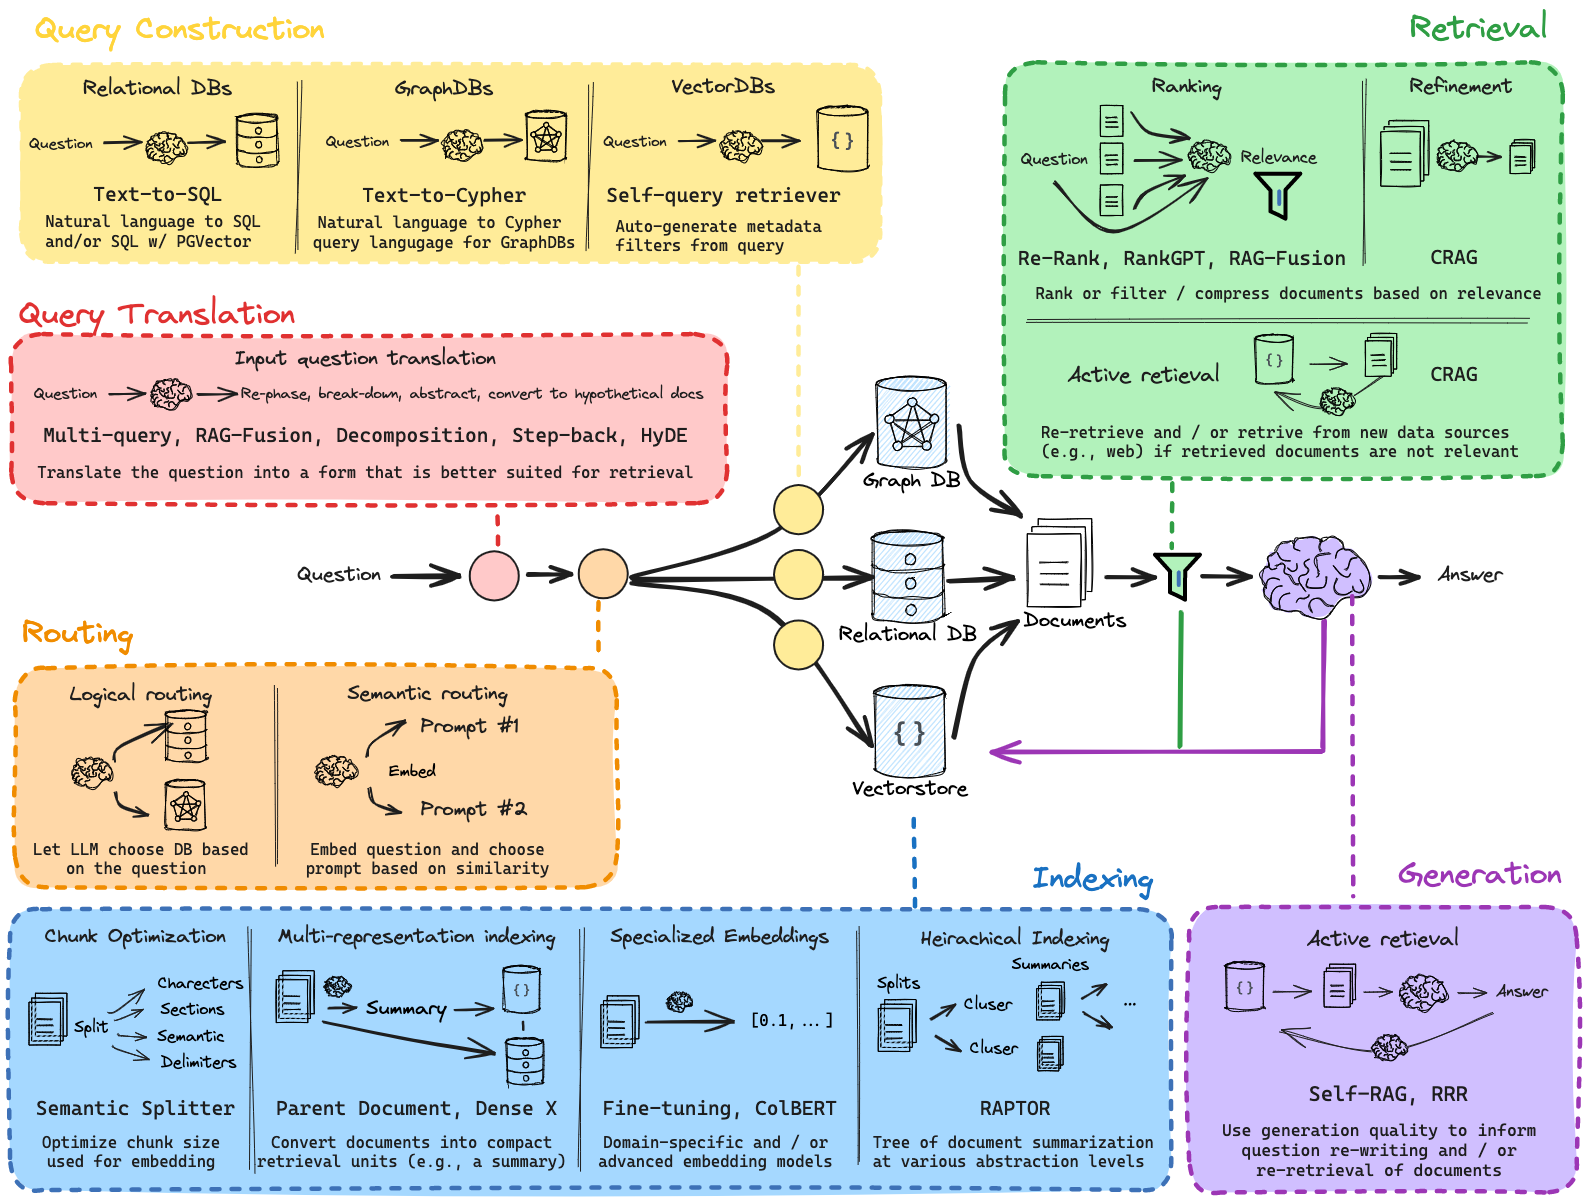